In [747]:
from qiskit import quantum_info as qi
import numpy as np
import pandas as pd
import scipy.linalg as lng
import random as rnd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:,.1f}'.format

In [748]:
def I0(L):
    label = ""
    for i in range(0,L):
        label += "I"
    return qi.Operator.from_label(label).data

def X(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Y(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def Z(l,L):
    label = ""
    for i in range(0,l):
        label += "I"
    label += "Z"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data
    
def gx(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "X"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def gy(l,L):
    label = ""
    for i in range(0,l):
        label += "Z"
    label += "Y"
    for i in range(l+1,L):
        label += "I"
    return qi.Operator.from_label(label).data

def cd(l,L):
    return 1/2*(gx(l,L)+1j*gy(l,L))

def c(l,L):
    return 1/2*(gx(l,L)-1j*gy(l,L))

In [749]:
def bkt(psi_a,U,psi_b):
    return np.dot(np.conjugate(psi_a),np.dot(U,psi_b))

def Mdot(Ol):
    m = Ol[0]
    for i in range(1,len(Ol)):
        m = np.dot(Ol[i],m)
    return m

## Define the Hamiltonian

$$ H = \mu\sum_{i=0}^N c^{\dagger}_i c_i + t \sum_{i=0}^{N-1} (c^{\dagger}_ic_{i+1} + c^{\dagger}_{i+1}c_i) + \Delta \sum_{i=0}^{N-1}(c^{\dagger}_i c^{\dagger}_{i+1} + c_{i+1}c_i) + U \sum_{i=0}^{N-1} c^{\dagger}_i c_i c^{\dagger}_{i+1} c_{i+1} $$

In [750]:
def H(mu,t,Delta,U,N):
    hm = mu*np.sum([Mdot([cd(n,N),c(n,N)]) for n in range(0,N)], axis = 0)
    ht = t*np.sum([Mdot([cd(n,N),c(n+1,N)]) + Mdot([cd(n+1,N),c(n,N)]) for n in range(0,N-1)], axis = 0)
    hD = Delta*np.sum([Mdot([cd(n,N),cd(n+1,N)])+Mdot([c(n+1,N),c(n,N)]) for n in range(0,N-1)],axis = 0)
    hU = U*np.sum([Mdot([cd(n,N),c(n,N),cd(n+1,N),c(n+1,N)]) for n in range(0,N-1)],axis = 0)
    return hm + ht + hD + hU

In [751]:
(e,y) = lng.eig(H(0.0,0.3,0.3,0.0,2))
psi = np.transpose(y)
e

array([ 0.3+0.j, -0.3+0.j,  0.3+0.j, -0.3+0.j])

## Define the Hamiltonian for two sites with Pauli operators

$$ H2 = \frac{\mu}{2}(2I - Z_0 - Z_1) + \frac{t}{2}(X_0 X_1 + Y_0 Y_1) + \frac{\Delta}{2} (X_0 X_1 - Y_0 Y_1) + \frac{U}{4} (I - Z_0 - Z_1 + Z_0 Z_1) $$

$$ H2 = \frac{4\mu+U}{4}I - \frac{2\mu+U}{4}(Z_0 + Z_1) + \frac{t+\Delta}{2}X_0 X_1 + \frac{t-\Delta}{2} Y_0 Y_1 + \frac{U}{4}  Z_0 Z_1 $$

In [752]:
def H2(mu,t,Delta,V):
    h0 = (4*mu+V)/4 * I0(2)
    hm = -(2*mu+V)/4 * (Z(0,2) + Z(1,2))
    ht = (t+Delta)/2 * Mdot([X(0,2),X(1,2)])
    hD = (t-Delta)/2 * Mdot([Y(0,2),Y(1,2)])
    hU = V/4*Mdot([Z(0,2),Z(1,2)])
    return h0 + hm + ht + hD + hU

In [753]:
np.amax(np.abs(H2(0.1,0.2,0.3,0.4) - H(0.1,0.2,0.3,0.4,2)))

1.1102230246251565e-16

In [754]:
(e,y) = lng.eig(H2(0.6,1.5,1.5,0.1))
psi = np.transpose(y)
e

array([-0.98477827+0.j,  2.28477827+0.j,  2.1       +0.j, -0.9       +0.j])

## Building the resonance Hamiltonian

$H = -\frac{1}{2} Z_0 + \epsilon_0 I + \epsilon_0 Z_1 + H_2 - Z_1 H_2 +c_x X_0 X_1$

In [755]:
L0 = int(np.log2(len(H2(0.0,0.0,0.0,0.0))))

Hb =-1/2*Z(0,L0+2)

def Hx(cx):
    return cx*(Mdot([X(0,L0+2),X(1,L0+2)])) 

def HR(w,mu,t,Delta,U):
    w0 = w+1
    L = L0+1
    return (w0*I0(L)+w0*Z(0,L)+np.kron(I0(1),H2(mu,t,Delta,U))-np.kron(Z(0,1),H2(mu,t,Delta,U)))/2

def Hrt(cx,w,mu,t,Delta,U):
    return Hb + Hx(cx) + np.kron(I0(1),HR(w,mu,t,Delta,U))

Htst = Hrt(cx,w,mu,T,D,V)

## Time evolution using the full exponential

In [756]:
def U(cx,w,mu,T,Delta,U,t):
    e,psi_d = lng.eig(Hrt(cx,w,mu,T,Delta,U))
    psi = np.conjugate(np.transpose(psi_d))
    eD = np.diag(e)
    exp = np.exp(1j*e*t)
    expD = np.diag(exp)
    return Mdot([psi,expD,psi_d])

Utst = U(cx,w,mu,T,D,V,t)

In [757]:
mu = 0.1
T = 7.0
D = -2.0
V = 0.05

(e0,y) = lng.eig(H2(mu,T,D,V))
psi = np.transpose(y)
e0

array([-1.87890244+0.j,  2.12890244+0.j,  7.1       +0.j, -6.9       +0.j])

In [768]:
#psiA = qi.Statevector.from_label('0000').data
psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-+').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+-').data + np.sqrt(0.3)*qi.Statevector.from_label('00++').data
psiA = psiA/np.sqrt(bkt(psiA,I0(4),psiA))

wl = [wi*0.1-10 for wi in range(0,200)]

t = 200.0
t = 5
cx = 0.2
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    psiS = Mdot([U(cx,w,mu,T,D,V,t),psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)

    pl.append(pw)

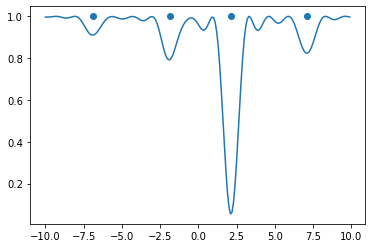

In [769]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()

## Using broken up exponential to match the circuit

$Hrt = -\frac{1}{2} Z_0 + \frac{1}{2}(\epsilon_0 I + \epsilon_0 Z_1 + H_2 - Z_1 H_2) +c_x X_0 X_1$

$H_2 = \frac{4\mu+U}{4}I - \frac{2\mu+U}{4}(Z_2 + Z_3) + \frac{t+\Delta}{2}X_2 X_3 + \frac{t-\Delta}{2} Y_2 Y_3 + \frac{U}{4}  Z_2 Z_3$

$Hrt = -\frac{1}{2} Z_0 + \frac{\epsilon_0}{2} I + \frac{\epsilon_0}{2} Z_1  + c_x X_0 X_1 + \frac{4\mu+U}{8}I - \frac{2\mu+U}{8}(Z_2 + Z_3) + \frac{t+\Delta}{4}X_2 X_3 + \frac{t-\Delta}{4} Y_2 Y_3 + \frac{U}{8}  Z_2 Z_3 -  (\frac{4\mu+U}{8}Z_1 - \frac{2\mu+U}{8}(Z_1 Z_2 + Z_1 Z_3) + \frac{t+\Delta}{4}Z_1 X_2 X_3 + \frac{t-\Delta}{4} Z_1 Y_2 Y_3 + \frac{U}{8}  Z_1 Z_2 Z_3)$

define: 

$E = \frac{4\mu+U}{8}$,
$\bar{\epsilon_0} = \frac{\epsilon_0}{2}$, 
$\bar{\mu} = \frac{2\mu+U}{8}$, 

$x = \frac{t+\Delta}{4}$, 
$y = \frac{t-\Delta}{4}$, 
$z = \frac{U}{8}$

$Hrt = (\bar{\epsilon_0}+E) I  - \frac{1}{2} Z_0 + (\bar{\epsilon_0}-E) Z_1  - \bar{\mu} Z_2 - \bar{\mu} Z_3  + c_x X_0 X_1  + x X_2 X_3 + y Y_2 Y_3 + z Z_2 Z_3  + \bar{\mu} Z_1 Z_2 +\bar{\mu} Z_1 Z_3 - x Z_1 X_2 X_3 - y Z_1 Y_2 Y_3 - z  Z_1 Z_2 Z_3$

\begin{equation}
\begin{split}
U(dt) \approx & e^{i(\bar{\epsilon_0}+E)dt} e^{-i \frac{1}{2} Z_0 dt} e^{i(\bar{\epsilon_0}-E) Z_1 dt}  e^{-i \bar{\mu} Z_2 dt} e^{-i \bar{\mu} Z_3 dt}
\\
& e^{i c_x X_0 X_1 dt} e^{i \bar{\mu}Z_1 Z_2 dt} e^{i \bar{\mu} Z_1 Z_3dt} e^{i x X_2 X_3 dt} e^{i y Y_2 Y_3 dt} e^{i z Z_2 Z_3 dt} 
\\
& e^{ -i x Z_1 X_2 X_3 dt} e^{-i y Z_1 Y_2 Y_3 dt} e^{-i z  Z_1 Z_2 Z_3 dt}
\end{split}
\end{equation}

Notice that all of three qubit gates involve $Z_1$.  I think we can apply controled-Z gates for free in which case there is no problem.  

Furthermore the only non-local gate is $Z_1 Z_3$ which I am almost certain we can apply for free.

In [770]:


def Hrt2(cx,w,mu,T,Delta,V):
    U=V
    t=T
    E = (4*mu+V)/4
    u = (2*mu+V)/4
    x = (T+Delta)/2
    y = (T-Delta)/2
    z = V/4
    w0 = w+1
    L = 3
    L0=2
    
    ha = (w0/2+E/2)*I0(4)
    
    hb = -1/2*Z(0,4)
    hc = (w0-E)/2*Z(1,4)
    hd = -u/2 * Z(2,4) 
    he = -u/2 * (Z(3,4))
    
    hf = cx*Mdot([X(0,4),X(1,4)])
    hg = u/2 * Mdot([Z(1,4),Z(2,4)])
    hh = u/2 * Mdot([Z(1,4),Z(3,4)])
    hi = x/2 * Mdot([X(2,4),X(3,4)])
    hj = y/2 * Mdot([Y(2,4),Y(3,4)])
    hk = z/2*Mdot([Z(2,4),Z(3,4)])
    
    hl = -x/2 * Mdot([Z(1,4),X(2,4),X(3,4)])
    hm = -y/2 * Mdot([Z(1,4),Y(2,4),Y(3,4)])
    hn = -z/2 * Mdot([Z(1,4),Z(2,4),Z(3,4)])

    return ha + hb + hc + hd + he + hf + hg + hh + hi + hj + hk + hl + hm + hn




np.amax(np.abs(Hrt(cx,w,mu,T,D,V) - Hrt2(cx,w,mu,T,D,V)))

7.771561172376096e-16

In [771]:
def UT(cx,w,mu,T,Delta,V,dt):
    E = (4*mu+V)/8
    u = (2*mu+V)/8
    x = (T+Delta)/4
    y = (T-Delta)/4
    z = V/8
    w0 = (w+1)/2
    
    Ub = np.cos(-1/2*dt)*I0(4) + 1j* np.sin(-1/2*dt)*Z(0,4)
    Uc = np.cos((w0 - E)*dt)*I0(4) + 1j* np.sin((w0 - E)*dt)*Z(1,4)
    Ud = np.cos(-u*dt)*I0(4) + 1j* np.sin(-u*dt)*Z(2,4)
    Ue = np.cos(-u*dt)*I0(4) + 1j* np.sin(-u*dt)*Z(3,4)
    
    Uf = np.cos(cx*dt)*I0(4) + 1j* np.sin(cx*dt)*Mdot([X(0,4),X(1,4)])
    Ug = np.cos(u*dt)*I0(4) + 1j* np.sin(u*dt)*Mdot([Z(1,4),Z(2,4)])
    Uh = np.cos(u*dt)*I0(4) + 1j* np.sin(u*dt)*Mdot([Z(1,4),Z(3,4)])
    Ui = np.cos(x*dt)*I0(4) + 1j* np.sin(x*dt)*Mdot([X(2,4),X(3,4)])
    Uj = np.cos(y*dt)*I0(4) + 1j* np.sin(y*dt)*Mdot([Y(2,4),Y(3,4)])
    Uk = np.cos(z*dt)*I0(4) + 1j* np.sin(z*dt)*Mdot([Z(2,4),Z(3,4)])
    
    Ul = np.cos(-x*dt)*I0(4) + 1j* np.sin(-x*dt)*Mdot([Z(1,4),X(2,4),X(3,4)])
    Um = np.cos(-y*dt)*I0(4) + 1j* np.sin(-y*dt)*Mdot([Z(1,4),Y(2,4),Y(3,4)])
    Un = np.cos(-z*dt)*I0(4) + 1j* np.sin(-z*dt)*Mdot([Z(1,4),Z(2,4),Z(3,4)])
    
    return np.exp(2*1j*(w0+E)*dt)*Mdot([Ub,Uc,Ud,Ue,Uf,Ug,Uh,Ui,Uj,Uk,Ul,Um,Un,Un,Um,Ul,Uk,Uj,Ui,Uh,Ug,Uf,Ue,Ud,Uc,Ub])

In [772]:
dt = 0.01
np.amax(np.abs(U(cx,w,mu,T,D,V,dt)-UT(cx,w,mu,T,D,V,dt/2)))

1.370856830073185e-06

In [775]:
psiA = np.sqrt(0.2)*qi.Statevector.from_label('00-+').data ++np.sqrt(0.7)*qi.Statevector.from_label('00+-').data + np.sqrt(0.3)*qi.Statevector.from_label('00++').data
psiA = psiA/np.sqrt(bkt(psiA,I0(4),psiA))

wl = [wi*0.1-10 for wi in range(0,200)]

t = 200.0
t = 5
dt = 0.1
cx = 0.2
Ns = 100
pl = []
for w in wl:
    psiS = psiA
    UTw = UT(cx,w,mu,T,D,V,dt/2)
    for ti in range(0,int(t/dt)):
        psiS = Mdot([UTw,psiS])
    pw = bkt(psiS,Z(0,L0+2),psiS)
    print(w,pw)

    pl.append(pw)

-10.0 (0.9960378320331265+0j)
-9.9 (0.9958329767305693+0j)
-9.8 (0.9961137891403534+0j)
-9.7 (0.9968257539374127+0j)
-9.6 (0.9977968174354102+0j)
-9.5 (0.9987701508601842+0j)
-9.4 (0.9994606797760138+0j)
-9.3 (0.9996235763438404+0j)
-9.2 (0.9991191536373161+0j)
-9.1 (0.9979582398751731+0j)
-9.0 (0.9963154333277674+0j)
-8.9 (0.9945040993142182+0j)
-8.8 (0.9929152752728921+0j)
-8.7 (0.991931019740067+0j)
-8.6 (0.9918292966722664+0j)
-8.5 (0.992700668648443+0j)
-8.4 (0.9943960057644311+0j)
-8.3 (0.9965191313869864+0j)
-8.2 (0.9984697810334155+0j)
-8.1 (0.9995321525796765+0j)
-8.0 (0.9989947721903428+0j)
-7.9 (0.9962804286644542+0j)
-7.8 (0.991062070284894+0j)
-7.699999999999999 (0.9833424937763137+0j)
-7.6 (0.9734820554035283+0j)
-7.5 (0.962168221236439+0j)
-7.4 (0.9503315909862153+0j)
-7.3 (0.9390228659957908+0j)
-7.199999999999999 (0.9292720997280175+0j)
-7.1 (0.9219541349287738+0j)
-7.0 (0.9176819978568416+0j)
-6.9 (0.9167437959898175+0j)
-6.8 (0.9190898129683064+0j)
-6.699999999999999

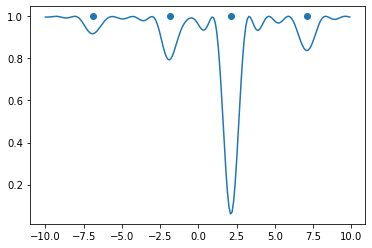

In [776]:
marker = [1 for i in e0]

plt.plot(wl,pl)
plt.scatter(e0,marker)
plt.show()